In [1]:
suppressPackageStartupMessages(library(clusterProfiler))
library(ggrepel)
library(magrittr)
library(cowplot)
library(tidyverse)

palette <- c('HSIC Lasso' = '#c994c7', 'Block HSIC Lasso, B = 50' = '#df65b0',
             'Block HSIC Lasso, B = 20' = '#e7298a', 'Block HSIC Lasso, B = 10' = '#ce1256',
             'Block HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443', 'Raw' = 'gray70')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
palette_yn = c("Yes" = "#91cf60", "No" = "#d6604d")

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.3.0     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ purrr::flatten()   masks jsonlite::flatten()
✖ cowplot::ggsave()  masks ggplot2::ggsave()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
✖ purrr::simplify()  masks clusterProfiler::simplify()


# Figure 1

In [2]:
fct_feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
fct_causal <- c('5 causal', '10 causal', '20 causal')

methods <- c('HSIC Lasso', 'Block HSIC Lasso, B = 20',
             'mRMR', 'Block HSIC Lasso, B = 10',
             'LARS', 'Block HSIC Lasso, B = 5',  'Raw')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = gsub('HSIC Lasso-B=', 'Block HSIC Lasso, B = ', model),
           model = gsub('-M=3', '', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples')),
           causal_txt = factor(paste(causal, 'causal'), levels = fct_causal),
           features_txt = factor(paste(features, 'features'), levels = fct_feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

features <- read_tsv('../results/benchmark/random_feature_selection.tsv', 
                     col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup

options(repr.plot.width=8, repr.plot.height=8)
fig1 <- ggplot(features, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom',
          panel.grid.minor = element_blank()) + 
    labs(x = '# features', y = '% true features', color = 'Algorithm') +
    facet_grid(causal_txt ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette) + 
    guides(color = guide_legend(nrow = 3, byrow = TRUE))

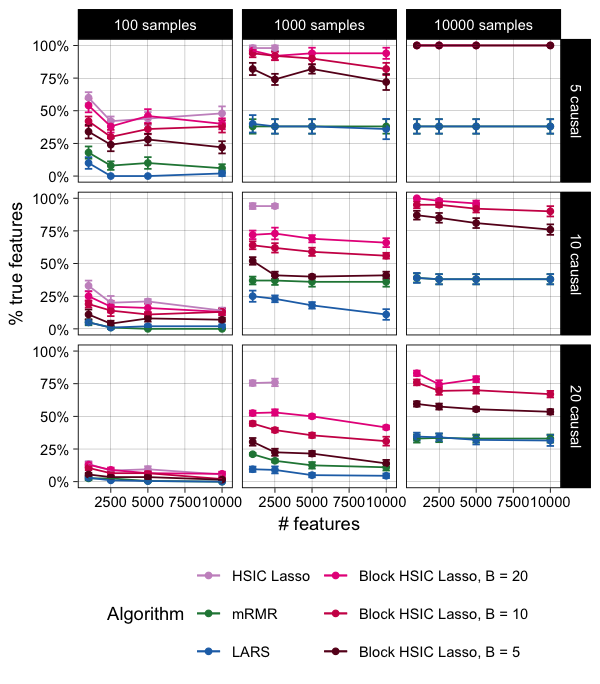

In [3]:
ggsave('img/figure_1.pdf', fig1, width = 5.5, height = 6)
options(repr.plot.width = 5, repr.plot.height = 5.7)
fig1

# Figure 2

In [4]:
summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('HSIC Lasso-B=', 'Block HSIC Lasso, B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

CLLSUB111 <- summarize_benchmark('../results/asu/CLL-SUB-111_prediction.tsv')
tox171 <- summarize_benchmark('../results/asu/TOX-171_prediction.tsv')
glioma <- summarize_benchmark('../results/asu/GLIOMA_prediction.tsv')
smkcan187 <- summarize_benchmark('../results/asu/SMK_CAN_187_prediction.tsv')

methods <- c('HSIC Lasso', 'mRMR',
             'Block HSIC Lasso, B = 10', 'LARS', 
             'Block HSIC Lasso, B = 5', 'Raw')

prediction_ma <- bind_rows(CLLSUB111, tox171, glioma, smkcan187) %>%
    mutate(model = factor(model, levels = methods))

ma <- prediction_ma %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        geom_hline(data = filter(prediction_ma, model == 'Raw'), aes(yintercept = accuracy), colour = 'gray20', alpha = 0.5) +
        theme_linedraw() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1),
              panel.grid.minor = element_blank()) + 
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Algorithm') +
        scale_color_manual(values = palette) +
        facet_wrap(~label, nrow = 2) + 
        guides(color = guide_legend(nrow = 3, byrow = TRUE))

legend <- get_legend(ma + theme(legend.position = 'bottom'))

Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”Warning message:
“Removed 4 rows containing missing values (geom_errorbar).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

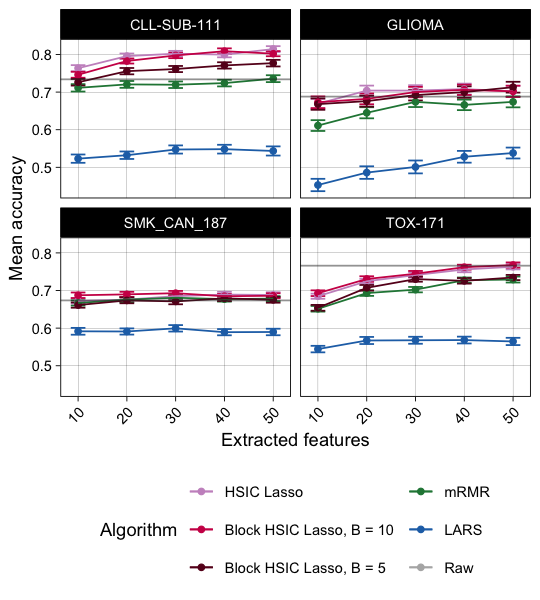

In [5]:
ggsave('img/figure_2.pdf', ma, width = 4.5, height = 5)
options(repr.plot.width = 4.5, repr.plot.height = 5)
ma

# Figure 4

In [6]:
manhattan <- function(pheno) {
    
    results <- '../results/gwas/' 
    
    map <- read_tsv('../results/gwas/t1d/controls.bim',
                    col_names = F, col_types = 'iciiii') %>%
           set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
           select(-cm, -x1, -x2)
    
    snp2gene <- read_tsv(paste0(results, 'snp2hgnc.tsv'), 
                     col_types = 'cc')
    
    selected <- read_tsv(paste0(results, pheno, '/', pheno, 
                                '_hsic_lasso_C=50_SELECT=50_M=3_B=20.txt'), 
                     col_names = F, col_types = 'c') %>%
        set_colnames('snp') %>%
        .$snp
    
    gwas <- read_tsv(paste0(results, pheno, '/univariate_models.tsv'),
                     col_types = 'icddcccd') %>%
        rename(chr = CHR, snp = SNP) %>%
        group_by(chr, snp) %>%
        summarise(P = min(P)) %>%
        ungroup %>%
        inner_join(map, by = c('chr', 'snp')) %>%
        mutate(selected = ifelse(snp %in% selected, 'Yes', 'No')) %>%
        arrange(selected)

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate( BPcum=pos+tot) %>%
      left_join(arrange(snp2gene, symbol) %>% group_by(snp) %>% summarize(symbol = head(symbol, 1)), by = 'snp')

    bf_threshold <- .05 / (4 * nrow(gwas))
    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
        scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(bf_threshold), color = 'red') +
    
        # add gene symbols
        geom_text_repel(data = filter(don, selected == 'Yes' & !is.na(symbol) & P > bf_threshold), 
                        aes(x=BPcum, y=-log10(P), label = symbol)) +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(p-value)'))
    
}

In [7]:
t1d_plt <- manhattan('t1d')
t2d_plt <- manhattan('t2d')
ra_plt <- manhattan('ra')

fig4 <- plot_grid(t1d_plt, t2d_plt, ra_plt, nrow = 3,
                  labels = c('T1D', 'T2D', 'RA'))

Warning message:
“Removed 19263 rows containing missing values (geom_point).”Warning message:
“Removed 13643 rows containing missing values (geom_point).”Warning message:
“Removed 12048 rows containing missing values (geom_point).”

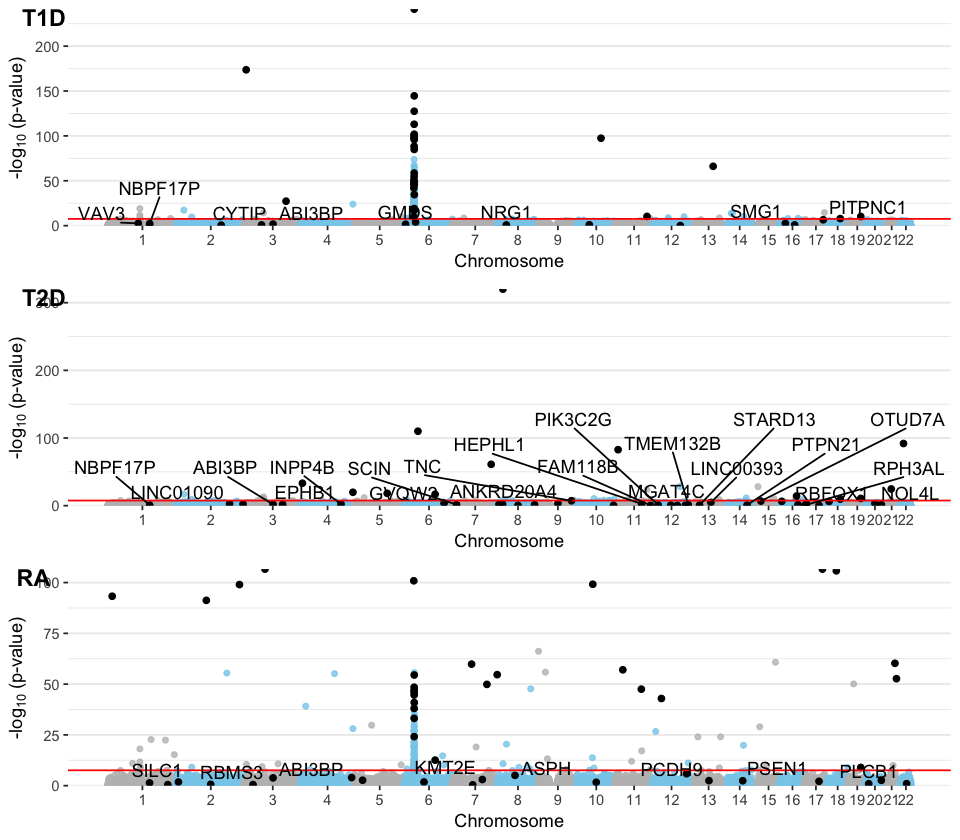

In [8]:
ggsave('img/figure_4.png', fig4, width = 8, height = 7)
ggsave('img/figure_4.pdf', fig4, width = 8, height = 7)
options(repr.plot.width=8, repr.plot.height=7)
fig4

# Figure 3

In [9]:
read_predictions <- function(label) {
    
    x <- bind_rows(read_tsv(paste0('../results/single_cell/', label, '_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt'), 
                            col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'HSIC Lasso') %>% head(n = 20),
          read_tsv(paste0('../results/single_cell/', label, '_lars_C=20.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'LARS'),
          read_tsv(paste0('../results/single_cell/', label, '_mrmr_C=20.txt'), 
                   col_names = 'Gene', col_types = 'c') %>%
              mutate(Method = 'mRMR'))
    
    # number of features selected
    print(table(x$Method))

    # number of features selected by more than one method
    x %>%
        group_by(Gene) %>%
        summarize(n = as.character(n())) %>%
        filter(n > 1) %>%
        print
    
    return(x)
    
}

gene2pathway <- function(genes, pathways) {
    
    rank <- inner_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        group_by(ont) %>%
        summarize(n = length(unique(Method)))

    left_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        left_join(rank, by = "ont") %>%
        arrange(-n) %>%
        group_by(Gene, Method) %>%
        summarize(ont = head(ont, 1)) %>%
        ungroup
    
}

plot_pathways <- function(genes, pathways) {
    
    gene2pathway(genes, pathways) %>%
        filter(!is.na(ont)) %>%
        group_by(ont) %>%
        filter(length(unique(Method)) >= 2) %>%
        ungroup %>%
        ggplot(aes(fct_infreq(ont), fill = Method)) +
            geom_bar() + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position = 'bottom') +
            labs(x = '', y = 'Count') +
            coord_flip() +
            scale_fill_manual(values = palette)
    
}

In [10]:
habib <- read_predictions('habib')

pathways_mouse <- suppressPackageStartupMessages(
    read.gmt(gmtfile = "../data/Mus_musculus_GSEA_GO_sets_bp_symbols_highquality_April_2015.gmt")) %>%
    mutate(ont = gsub('\\([0-9]\\)', '', ont),
           gene = tools::toTitleCase(tolower(gene)),
           ont = tools::toTitleCase(ont),
           ont = gsub('_', ' ', ont))

detach(package:clusterProfiler)


HSIC Lasso       LARS       mRMR 
        20         16         20 
# A tibble: 0 x 2
# ... with 2 variables: Gene <chr>, n <chr>


In [11]:
markers <- c(read_tsv('~/data/single_cell/habib/Major_cell_types_marker_genes.txt',
                      col_types = 'cddddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/Glia_subcluster_marker_genes.txt',
                         col_types = 'cdddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/GABAergic_edit_subcluster_marker_gene.txt',
                         col_types = 'cdddddddd') %>% .$`GENE NAMES`)

markers_pwy <- data_frame(Gene = markers, Method = 'Known genes') %>%
    gene2pathway(pathways_mouse) %>%
    .$ont %>%
    unique %>%
    na.omit

known_genes <- habib %>% 
    mutate(known_gene = ifelse(Gene %in% markers, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_gene)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known gene?') +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank())

known_pwy <- gene2pathway(habib, pathways_mouse) %>%
    mutate(known_pwy = ifelse(ont %in% markers_pwy, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_pwy)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known BP?') +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank())

fig3 <- plot_grid(known_genes, known_pwy, labels = c('A','B'))

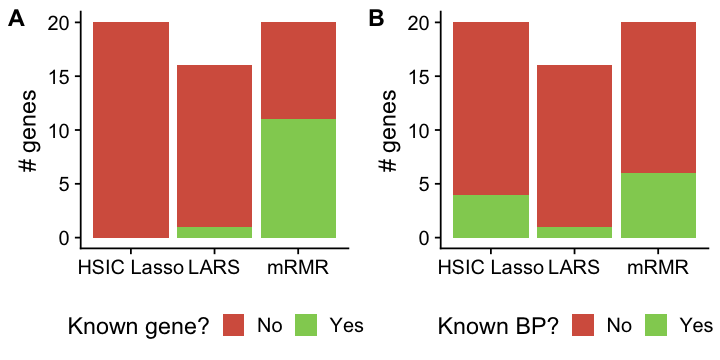

In [12]:
ggsave('img/figure_3.pdf', fig3, width = 6.8, height = 3.8)
options(repr.plot.width=6, repr.plot.height=3)
fig3